# Retrain a classification model for Edge TPU using post-training quantization (with TF2)

In this guide, we will utilize TensorFlow 2 to construct an image classification model, train it using a cat & dog dataset, and convert it into TensorFlow Lite through post-training quantization. The model is built upon a pre-trained MobileNet V2, where we initially retrain only the classification layers while reusing the pre-trained feature extractor layers. Subsequently, we fine-tune the model by updating weights in specific feature extractor layers, a faster approach compared to training the entire model from the ground up. Following the training, we employ post-training quantization to convert all parameters to int8 format, reducing the model size and enhancing inference speed. This int8 format is crucial for compatibility with the Edge TPU found in Coral devices.

Refer to the [coral.ai documentation](https://coral.ai/docs/edgetpu/models-intro/) for additional information on creating Edge TPU-compatible models. It's important to note that this tutorial requires TensorFlow 2.3 or later for full quantization, and it specifically expects a Keras-built model. This conversion strategy is not compatible with models imported from a frozen graph. If using TensorFlow 1.x, you can refer to [the 1.x version of this tutorial](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf1.ipynb).

## Import the required libraries

To perform quantization on both input and output tensors, you must utilize the `TFLiteConverter` APIs, which are accessible in TensorFlow versions equal to or greater than r2.3.

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

## Prepare the training data

Initially, we will download and arrange the cat & dog dataset intended for retraining the model. It is essential to pay close attention to this section for future replication with your custom image dataset. Specifically, observe that the "PATH" directory is organized with directories bearing appropriate names for each class. The provided code randomizes and partitions the photos into training and validation sets, creating a labels file derived from the names of the photo folders.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68606236/68606236 [==============================] - 1s 0us/step


In [3]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

Next, we use [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to rescale the image data into float values (divide by 255 so the tensor values are between 0 and 1), and call `flow_from_directory()` to create two generators: one for the training dataset and one for the validation dataset.


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Change if you have a different problem (e.g., binary)
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Change if you have a different problem (e.g., binary)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.



On each iteration, these generators provide a batch of images by reading images from disk and processing them to the proper tensor size (224 x 224). The output is a tuple of (images, labels). For example, you can see the shapes here:

In [5]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

Now save the class labels to a text file:

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('catdogs_labels.txt', 'w') as f:
  f.write(labels)

{'cats': 0, 'dogs': 1}


In [7]:
!cat catdogs_labels.txt

cats
dogs

## Build the model

Now, we will build a model designed for transfer learning specifically on the final fully-connected layer.

Commencing with Keras' MobileNet V2 as the foundational model, which is initially pre-trained on the ImageNet dataset (encompassing training for the recognition of 1,000 classes). This offers us an excellent feature extractor for image classification, enabling us to subsequently train a novel classification layer tailored to our flowers dataset.


In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=2, activation='softmax')
])

### Configure the model

Although this method is called `compile()`, it's basically a configuration step that's required before we can start training.

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 2626722 (10.02 MB)
Trainable params: 36873

In [12]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Train the model


Now we can train the model using data provided by the `train_generator` and `val_generator` that we created at the beginning.

This should take less than 10 minutes.

In [13]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
32/32 [==============================] - 20s 412ms/step - loss: 0.1278 - accuracy: 0.9500 - val_loss: 0.0657 - val_accuracy: 0.9760
Epoch 2/10
32/32 [==============================] - 9s 293ms/step - loss: 0.0354 - accuracy: 0.9865 - val_loss: 0.0680 - val_accuracy: 0.9780
Epoch 3/10
32/32 [==============================] - 12s 364ms/step - loss: 0.0120 - accuracy: 0.9960 - val_loss: 0.0842 - val_accuracy: 0.9780
Epoch 4/10
32/32 [==============================] - 9s 267ms/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.1042 - val_accuracy: 0.9780
Epoch 5/10
32/32 [==============================] - 9s 272ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1085 - val_accuracy: 0.9800
Epoch 6/10
32/32 [==============================] - 9s 292ms/step - loss: 0.0044 - accuracy: 0.9995 - val_loss: 0.1138 - val_accuracy: 0.9800
Epoch 7/10
32/32 [==============================] - 9s 293ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1159 - val_accuracy: 0.9780
Epoc

### Plot

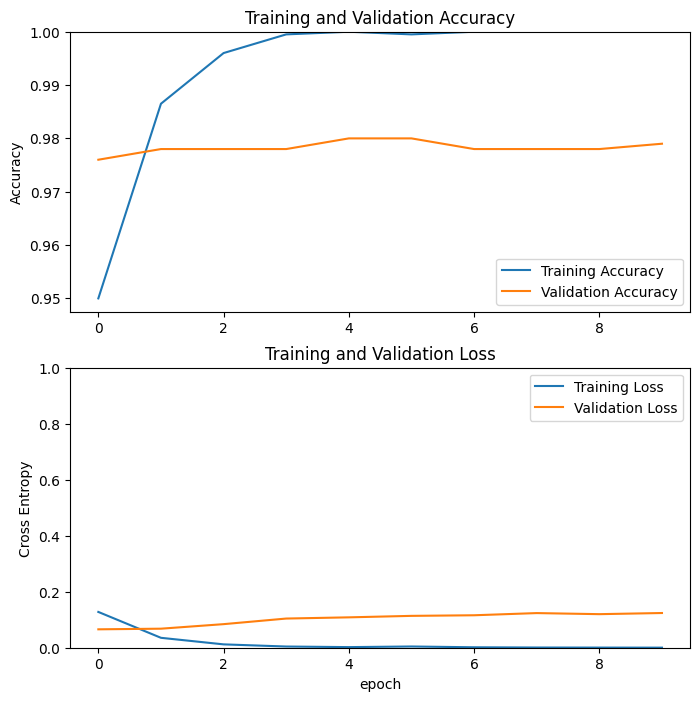

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model


So far, the training focused on the classification layers, and the weights of the pre-trained network remained *unchanged*.

To improve accuracy, one approach involves training or "fine-tuning" additional layers from the pre-trained model. In other words, we'll unfreeze specific layers from the base model and modify their weights, originally trained on 1,000 ImageNet classes, to better align with features present in our cat & dog dataset.

### Un-freeze more layers


So instead of freezing the entire base model, we'll freeze individual layers.

First, let's see how many layers are in the base model:

In [15]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Let's try freezing just the bottom 100 layers.

In [16]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Reconfigure the model

Now configure the model again, but this time with a lower learning rate (the default is 0.001).

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 2626722 (10.02 MB)
Trainable params: 22301

In [19]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


### Continue training

Now let's fine-tune all trainable layers. This starts with the weights we already trained in the classification layers, so we don't need as many epochs.

In [20]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
32/32 [==============================] - 23s 379ms/step - loss: 0.4048 - accuracy: 0.9100 - val_loss: 0.1235 - val_accuracy: 0.9790
Epoch 2/5
32/32 [==============================] - 10s 301ms/step - loss: 0.0848 - accuracy: 0.9700 - val_loss: 0.1214 - val_accuracy: 0.9810
Epoch 3/5
32/32 [==============================] - 11s 355ms/step - loss: 0.0692 - accuracy: 0.9760 - val_loss: 0.1209 - val_accuracy: 0.9810
Epoch 4/5
32/32 [==============================] - 9s 274ms/step - loss: 0.0379 - accuracy: 0.9855 - val_loss: 0.1182 - val_accuracy: 0.9800
Epoch 5/5
32/32 [==============================] - 10s 302ms/step - loss: 0.0289 - accuracy: 0.9885 - val_loss: 0.1172 - val_accuracy: 0.9800


### New Plot

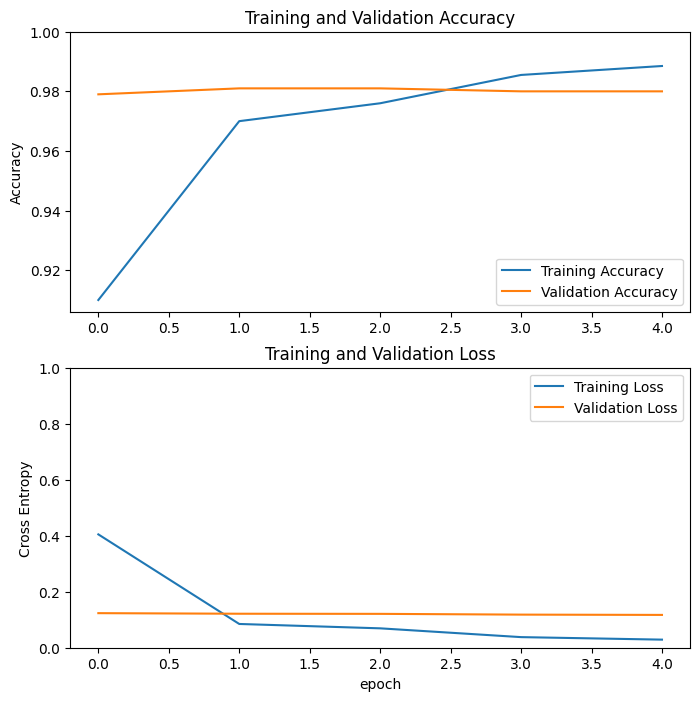

In [21]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Convert to TFLite

Ordinarily, creating a TensorFlow Lite model is just a few lines of code with [`TFLiteConverter`](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter). For example, this creates a basic (un-quantized) TensorFlow Lite model:

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

However, this `.tflite` file still uses floating-point values for the parameter data, and we need to fully quantize the model to int8 format.

To fully quantize the model, we need to perform [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) with a representative dataset, which requires a few more arguments for the `TFLiteConverter`, and a function that builds a dataset that's representative of the training dataset.

So let's convert the model again with post-training quantization:

In [23]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(PATH + '/train/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### Compare the accuracy


So now we have a fully quantized TensorFlow Lite model. To be sure the conversion went well, let's evaluate both the raw model and the TensorFlow Lite model.

First check the accuracy of the raw model:

In [24]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 96.875%


Now let's check the accuracy of the `.tflite` file, using the same dataset.

However, there's no convenient API to evaluate the accuracy of a TensorFlow Lite model, so this code runs several inferences and compares the predictions against ground truth:

In [25]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 95.312%


You might see some, but hopefully not very much accuracy drop between the raw model and the TensorFlow Lite model. But again, these results are not suitable for production deployment.

## Compile for the Edge TPU


Finally, we're ready to compile the model for the Edge TPU.

First download the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

In [26]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  26184      0 --:--:-- --:--:-- --:--:-- 26326
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [663 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Ign:8 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages
Get:9 http://archive.ubuntu.com/ub

Then compile the model:

In [27]:
! edgetpu_compiler mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1184 ms.

Input model: mobilenet_v2_1.0_224_quant.tflite
Input size: 2.94MiB
Output model: mobilenet_v2_1.0_224_quant_edgetpu.tflite
Output size: 3.12MiB
On-chip memory used for caching model parameters: 3.33MiB
On-chip memory remaining for caching model parameters: 4.36MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_1.0_224_quant_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


That's it.

The compiled model uses the same filename but with "_edgetpu" appended at the end.

## Download the model

You can download the converted model and labels file from Colab like this:

In [ ]:
from google.colab import files

files.download('mobilenet_v2_1.0_224_quant_edgetpu.tflite')
files.download('catdogs_labels.txt')

If you get a "Failed to fetch" error here, it's probably because the files weren't done saving. So just wait a moment and try again.

Also look out for a browser popup that might need approval to download the files.

## Run the model on the Edge TPU




You can now run the model on your Coral device with acceleration on the Edge TPU.

To get started, try using your `.tflite` model with [this code for image classification with the TensorFlow Lite API](https://github.com/google-coral/tflite/tree/master/python/examples/classification).

Just follow the instructions on that page to set up your device, copy the `mobilenet_v2_1.0_224_quant_edgetpu.tflite` and `flower_labels.txt` files to your Coral Dev Board or device with a Coral Accelerator, and pass it a flower photo like this:

```
python3 classify_image.py \
  --model mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --labels flower_labels.txt \
  --input flower.jpg
```

This notebook got reference from [coral.ai/examples](https://coral.ai/examples/#code-examples/). Check more example there